In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Aplicaciones Avanzadas/DataBank"
!ls

/content/drive/MyDrive/Aplicaciones Avanzadas/DataBank
fake_news_dataset.csv


In [63]:
# Importación de librerías
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

# Obtener el set de datos



Se obtuvo el dataset de noticias falsas de la plataforma Kaggle y se almacenó en Google Drive

In [5]:
# Lectura del archivo
df = pd.read_csv('fake_news_dataset.csv')

In [6]:
# Vista inicial del dataset
print(df.head())
print(df.info())
print(df.isnull().sum())

                                  title  \
0               Foreign Democrat final.   
1   To offer down resource great point.   
2          Himself church myself carry.   
3                  You unit its should.   
4  Billion believe employee summer how.   

                                                text        date    source  \
0  more tax development both store agreement lawy...  2023-03-10  NY Times   
1  probably guess western behind likely next inve...  2022-05-25  Fox News   
2  them identify forward present success risk sev...  2022-09-01       CNN   
3  phone which item yard Republican safe where po...  2023-02-07   Reuters   
4  wonder myself fact difficult course forget exa...  2023-04-03       CNN   

                 author    category label  
0          Paula George    Politics  real  
1           Joseph Hill    Politics  fake  
2        Julia Robinson    Business  fake  
3  Mr. David Foster DDS     Science  fake  
4         Austin Walker  Technology  fake  
<class '

In [7]:
# Dimension del dataset (filas, columnas)
df.shape

(20000, 7)

In [8]:
print(df['label'].value_counts())


label
fake    10056
real     9944
Name: count, dtype: int64


# Separación del set de pruebas y del set de entrenamiento

Eliminar palabras vacías que no aportan significado relevante con *Stopwords*

In [9]:
# Descargar stopwords (solo la primera vez)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Función para la limpieza del texto
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a Minúsculas
    texto = re.sub(r'\d+', '', texto)  # Quitar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Quitar signos de puntuación
    texto = texto.strip()  # Eliminar espacios al inicio/final
    texto = re.sub(r'\s+', ' ', texto)  # Espacios múltiples → uno solo

    # Eliminar stopwords
    palabras = texto.split()
    palabras = [p for p in palabras if p not in stop_words]
    return ' '.join(palabras)

***Label Encoding***

Para distinguir el target a binario,  se utilizará el Label encoder, ya que:

*   Solo hay dos categorias (fake, real)
*   Normaliza etiquetas en valores numéricos
*   Se utiliza menos memoria


In [100]:
# Rellenar valores nulos
df = df.fillna('')

# Combinación del título y texto de la noticia
df['content'] = df['title'] + ' ' + df['text']

# Codificar etiquetas con Label Encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Features seleccionadas (title y content) y etiquetas (label)
X = df['content']
y = df['label']

# Limpiar el contenido
df['content'] = df['content'].apply(limpiar_texto)

Dividimos el dataset para tener el conjunto que será para entrenamiento y el conjunto que será para pruebas (train y test)

In [91]:
# 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesado de datos

### Vectorización del texto (TF-IDF)

In [92]:
# Vectorización de los sets de prueba y de entrenamiento
#vectorizer = TfidfVectorizer(max_df=0.7) # Ignora términos que aparecen en más del 70% de los documentos.
TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_arr = X_train_tfidf.toarray()
X_test_arr = X_test_tfidf.toarray()

El **StandardScaler** se utiliza para estandarizar los datos, es decir, para escalar las características de los datos de entrada de modo que tengan una media de 0 y una desviación estándar de 1.

Como es una **matriz dispersa** en la que la mayoría de los valores son ceros (como las que suelen generarse al usar representaciones como TF-IDF en procesamiento de texto), se desactiva la opción (with_mean=False). Solo se toma en cuenta la desviación estandar. Se debe tener cuidado al escalar los datos para no romper su estructura dispersa.

In [93]:
scaler = StandardScaler(with_mean=False)  # with_mean=False porque es sparse matrix
X_train_scaled = scaler.fit_transform(X_train_arr)
X_test_scaled = scaler.transform(X_test_arr)




*   **Sequential**: Modelo de red neuronal donde las capas se apilan secuencialmente (una tras otra). Cada capa tiene exactamente un tensor de entrada y uno de salida, ideal para arquitecturas simples
*   **Dense**: Capa de neuronas totalmente conectada. Cada neurona recibe todas las salidas de la capa anterior.


*   **Dropout**:
Técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento para evitar el sobreajuste (overfitting)






.



In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Determine the input dimension based on the TF-IDF vectorizer
input_dim = X_train_scaled.shape[1]

# Sequential: Modelo de red neuronal donde las capas se apilan secuencialmente (una tras otra).


model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),# numero de neuronas que tiene la capa, 'relu' = capa intermedia
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Sigmoid is typically used for binary classification problems, producing a single output between 0 and 1 representing the probability of belonging to one class.
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Imprime el resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │       323,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,161 (1.27 MB)

 Trainable params: 332,161 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:

history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test), batch_size=64)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4886 - loss: 0.7502 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5337 - loss: 0.6872 - val_accuracy: 0.5098 - val_loss: 0.6977
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5957 - loss: 0.6601 - val_accuracy: 0.5175 - val_loss: 0.7073
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6578 - loss: 0.6063 - val_accuracy: 0.5190 - val_loss: 0.7393
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7200 - loss: 0.5316 - val_accuracy: 0.5155 - val_loss: 0.8043
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7875 - loss: 0.4387 - val_accuracy: 0.5163 - val_loss: 0.9532
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8559 - loss: 0.3275 - val_accuracy: 0.5157 - val_loss: 1.1393
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8931 - loss: 0.2500 - val_accuracy: 

In [96]:
# Run this cell to load the model history into a pandas DataFrame
frame = pd.DataFrame(history.history)

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

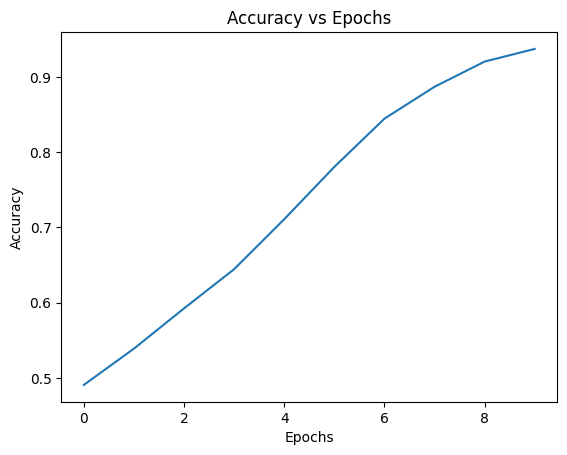

In [97]:
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

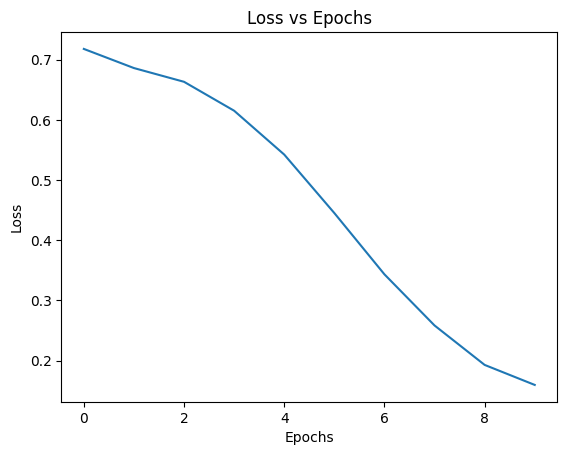

In [98]:
# Run this cell to make the Loss vs Epochs plot
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5143 - loss: 1.7930
Accuracy: 0.5184999704360962

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.55      2029
           1       0.51      0.47      0.49      1971

    accuracy                           0.52      4000
   macro avg       0.52      0.52      0.52      4000
weighted avg       0.52      0.52      0.52      4000



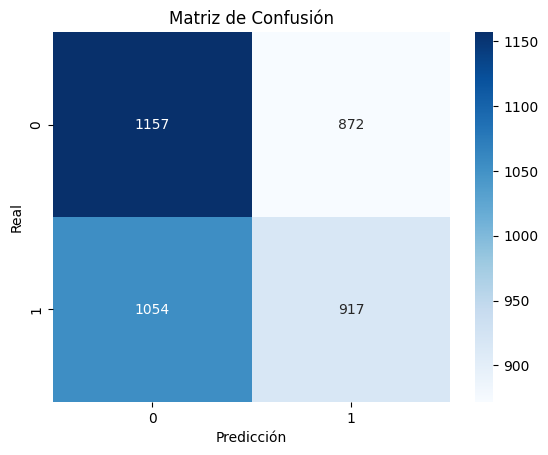

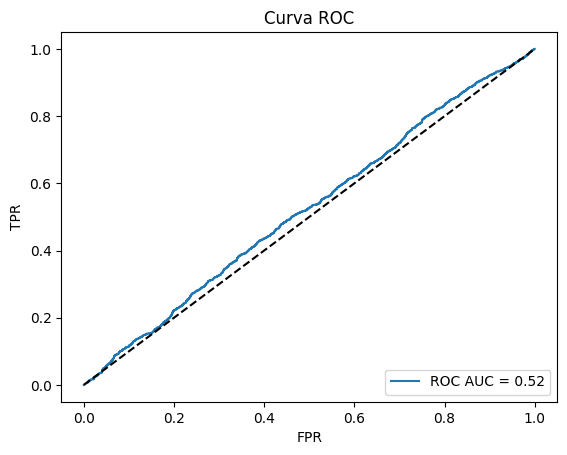

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np

# Predicciones
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Reporte

# Returns the loss value & metrics values for the model in test mode.
print("Accuracy:", model.evaluate(X_test_scaled, y_test)[1])

# Build a text report showing the main classification metrics.
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Get the inverse transformed labels
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

# Confusion matrix with original labels
cm = confusion_matrix(y_test_original, y_pred_original)

# Get the class labels from the LabelEncoder
class_labels = le.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


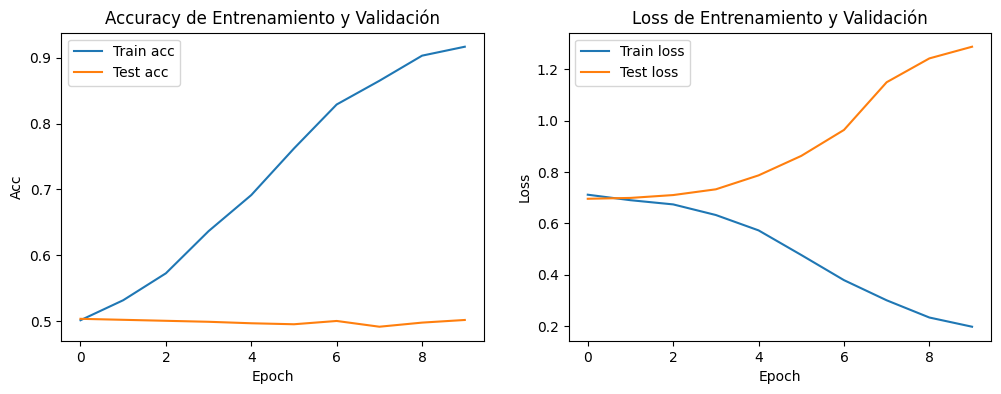

In [52]:
# Graficar precisión y pérdida a lo largo de las épocas
plt.figure(figsize=(12, 4))

# Graficar precisión de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Test acc')
plt.title('Accuracy de Entrenamiento y Validación')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

# Graficar pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Loss de Entrenamiento y Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()